### AMS 520 Kernel Learning Data

In [1]:
import pandas as pd
import sys
from datetime import datetime

path='/home/jbohn/jupyter/personal/sbu/Kernel_Learning'

sys.path.append(path)

# Data Set
- Trade and Quote Data for AAPL on NASDAQ between 01/01/2020 and 01/30/2020

### Preprocessing
- Removed trades outside of market hours


In [2]:
def clean_trades(trades):
    trades.index = pd.to_datetime(trades["Time"].values)
    

    trades["date"] = trades.index.date
    
    trades=trades[trades['Trade_Volume']>0]

    grouped_trades = trades.groupby("date").groups

    # drop trade data outside of market hours

    for day in grouped_trades.keys():
        subset = trades[trades["date"] == day]
        grouped_trades[day] = subset[
            subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
        ]
        grouped_trades[day] = subset[
            subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
        ]

    new_trades = pd.concat(list(grouped_trades.values())).sort_index()

    return new_trades


def clean_quotes(quotes, drop_after_hours=True):
    quotes.index = pd.to_datetime(quotes["Time"].values)
    
    quotes=quotes[quotes['Offer_Price']>quotes['Bid_Price']] # removed quotes with invalid spreads 
    
    quotes=quotes[quotes['Bid_Price']>0] # bid and offer price >0

    # drop after hours for quotes, preserve if want to prepend lob
    if drop_after_hours:
        quotes["date"] = quotes.index.date

        grouped_quotes = quotes.groupby("date").groups

        # drop trade data outside of market hours

        for day in grouped_quotes.keys():
            subset = quotes[quotes["date"] == day]
            grouped_quotes[day] = subset[
                subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
            ]
            grouped_quotes[day] = subset[
                subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
            ]
        new_quotes = pd.concat(list(grouped_quotes.values())).sort_index()
        
        return new_quotes
    else:
        return quotes


### Trade Features

In [3]:
trades=pd.read_csv(f"{path}/data/AAPL_trades.csv")
trades=clean_trades(trades)
trades.index=trades['Time']
trades=trades.drop(columns=trades.columns[:2])
trades

,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,date
Time,,,,,,,
2020-01-02 09:30:00.624116,N,AAPL,50,296.23,@ I,N,2020-01-02
2020-01-02 09:30:00.836409,N,AAPL,22,296.25,@ I,N,2020-01-02
2020-01-02 09:30:01.073828,N,AAPL,31,296.26,@ I,N,2020-01-02
2020-01-02 09:30:01.261512,N,AAPL,3,296.27,@ I,N,2020-01-02
2020-01-02 09:30:01.294279,N,AAPL,31,296.25,@ I,N,2020-01-02
...,...,...,...,...,...,...,...
2020-01-29 15:59:53.741022,N,AAPL,200,324.19,@,N,2020-01-29
2020-01-29 15:59:54.202375,N,AAPL,7,324.20,@F I,N,2020-01-29
2020-01-29 15:59:54.211587,N,AAPL,18,324.15,@F I,N,2020-01-29


### Examine properties of Trades
    - @ : Regular Trade
    - @F : Regular Intermarket Sweep
    - @I : Regular Odd Lot
    - @IF: Regular Odd Lot Intermarket Sweep

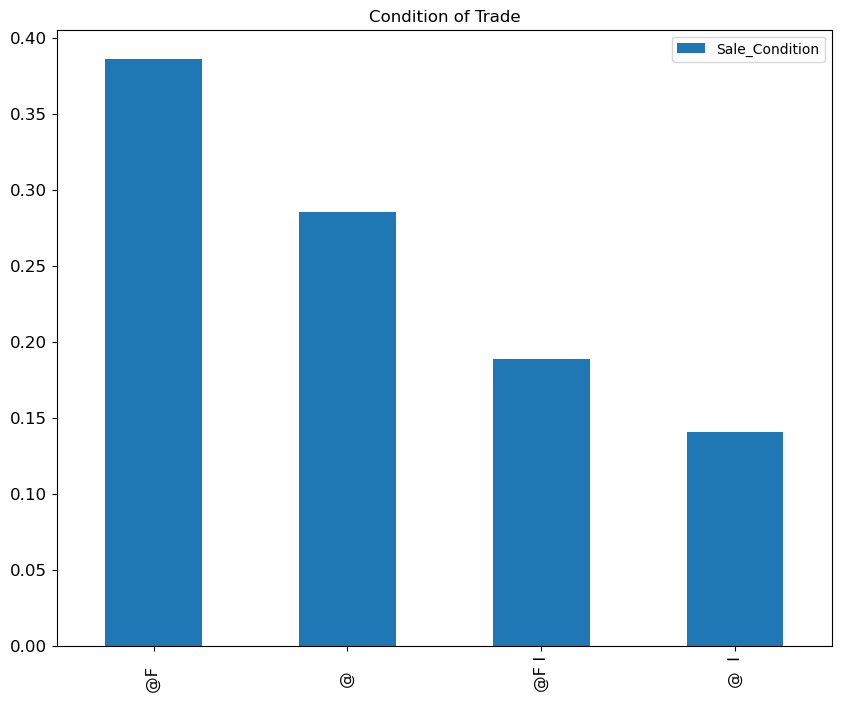

In [4]:
ax = (trades['Sale_Condition'].value_counts()/trades.shape[0]).plot(kind='bar', title ="Condition of Trade", figsize=(10,8), legend=True, fontsize=12)

<IPython.core.display.Javascript object>

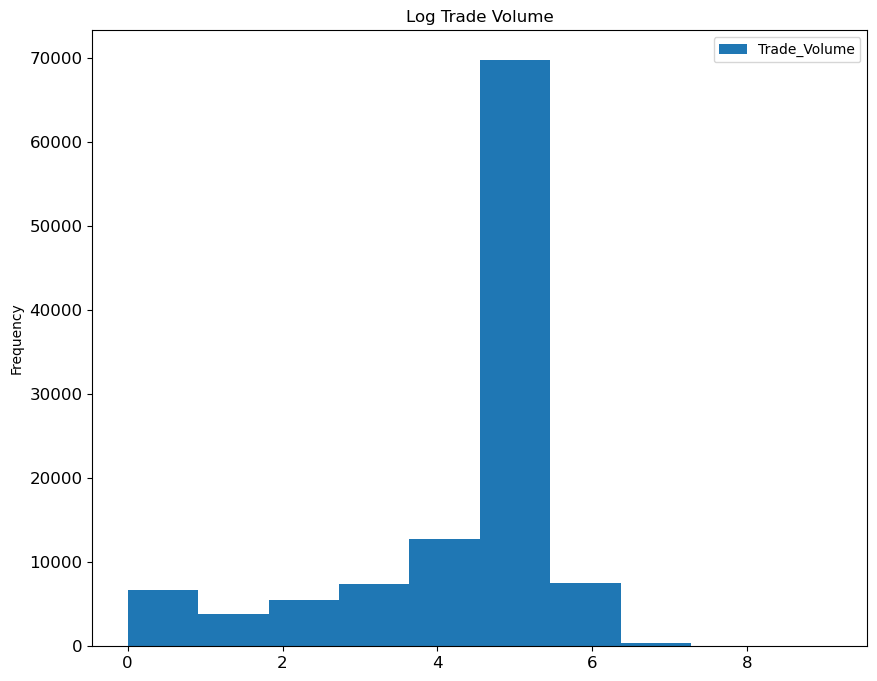

In [17]:
ax = np.log(trades['Trade_Volume']).plot(kind='hist', title ="Log Trade Volume", figsize=(10,8), legend=True, fontsize=12)

### Quote Features


In [9]:
quotes=pd.read_csv(f"{path}/data/AAPL_quotes.csv")
quotes=clean_quotes(quotes)
quotes.index=quotes['Time']
quotes=quotes.drop(columns=quotes.columns[:2])
quotes['Time']=quotes.index
quotes

,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,FINRA_BBO_Indicator,Source_Of_Quote,...,Best_Offer_Size,Best_Offer_FINRA_Market_Maker_ID,LULD_Indicator,LULD_NBBO_Indicator,SIP_Generated_Message_Identifier,Participant_Timestamp,FINRA_ADF_Timestamp,Security_Status_Indicator,date,Time
Time,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:03.297207,N,AAPL,295.70,1.0,296.75,6.0,R,37,NaN,N,...,2.0,NaN,NaN,A,NaN,75001344,0,,2020-01-02,2020-01-02 09:30:03.297207
2020-01-02 09:30:05.489581,N,AAPL,296.14,4.0,296.75,5.0,R,109,NaN,N,...,4.0,NaN,NaN,A,NaN,2267377152,0,,2020-01-02,2020-01-02 09:30:05.489581
2020-01-02 09:30:05.664062,N,AAPL,295.70,1.0,296.75,5.0,R,140,NaN,N,...,2.0,NaN,NaN,A,NaN,2441856512,0,,2020-01-02,2020-01-02 09:30:05.664062
2020-01-02 09:30:06.279237,N,AAPL,294.05,1.0,296.12,2.0,R,130,NaN,N,...,4.0,NaN,NaN,A,NaN,3057030912,0,,2020-01-02,2020-01-02 09:30:06.279237
2020-01-02 09:30:14.711372,N,AAPL,295.12,1.0,295.74,1.0,R,167,NaN,N,...,1.0,NaN,NaN,A,NaN,2899234816,0,,2020-01-02,2020-01-02 09:30:14.711372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175774,N,AAPL,300.41,2.0,300.66,1.0,R,81,NaN,N,...,4.0,NaN,NaN,A,NaN,3797782272,0,,2020-01-02,2020-01-02 15:59:41.175774
2020-01-02 15:59:46.114358,N,AAPL,300.29,3.0,300.46,1.0,R,24,NaN,N,...,2.0,NaN,NaN,A,NaN,146432256,0,,2020-01-02,2020-01-02 15:59:46.114358
2020-01-02 15:59:50.119320,N,AAPL,300.29,3.0,300.66,1.0,R,171,NaN,N,...,4.0,NaN,NaN,A,NaN,4151391744,0,,2020-01-02,2020-01-02 15:59:50.119320


### Construct LOB